# Example Plots

This notebook demonstrates the basic use of quantum reservoir computing on several sequences. The generated plot is used for publications.

---

This file is part of the `QuantumReservoirPy` project.

Last Updated: `2023-10-21`

Using Version: `0.1`

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.colors import ListedColormap

from qiskit.quantum_info import random_unitary
from qiskit_aer import AerSimulator

from quantumreservoirpy.reservoirs import Static

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

---

## Simple Examples

In [2]:
sequences = [[0, 1] * 280, [1, 1, 0, 0] * 140, [0, 1, 2, 0, 1, 1, 2] * 80]
data = np.zeros((2, 560, 1))
predictions = np.zeros((3, 20))

num_qubits = 4
operator = random_unitary(2 ** num_qubits, seed=416)

backend = AerSimulator()

In [3]:
class QuantumReservoir(Static):
    def during(self, circuit, timestep):
        circuit.initialize(str(timestep), 0)
        circuit.append(operator, circuit.qubits)
        circuit.measure(0)


Model 0 KNN Classifier Score Using Standard Reservoir: 0.9945652173913043


Predicting...: 100%|██████████| 20/20 [00:47<00:00,  2.37s/it]


Model 1 KNN Classifier Score Using Standard Reservoir: 0.9619565217391305


Predicting...: 100%|██████████| 20/20 [00:33<00:00,  1.70s/it]


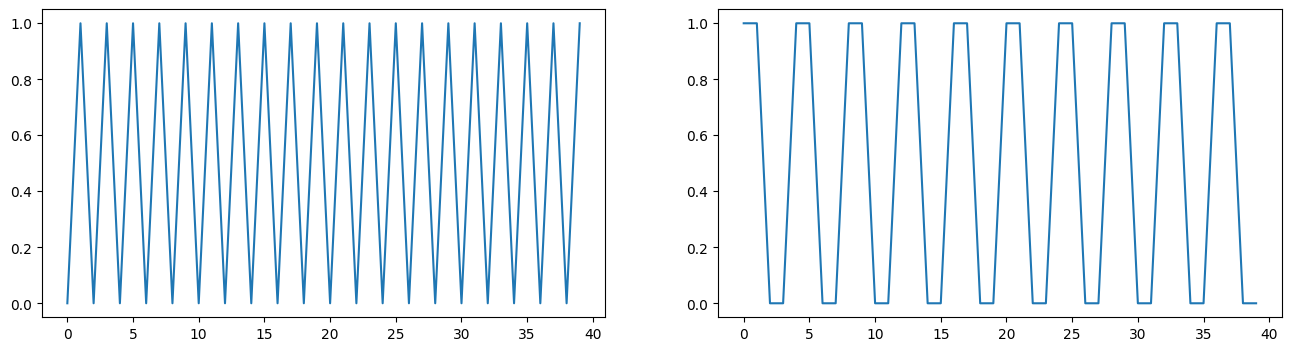

In [4]:
fig, axs = plt.subplots(1, len(sequences[0:2]))
fig.set_size_inches(16, 4)

for i, sequence in enumerate(sequences[0:2]):
    axs[i].plot(sequence[:40])

    res = QuantumReservoir(n_qubits=num_qubits, backend=backend)
    data[i] = res.run(timeseries=sequence)

    X_train, X_test, y_train, y_test = train_test_split(data[i][5:], np.roll(sequence, -1)[5:], test_size=0.33, random_state=171)

    model = KNeighborsClassifier(n_neighbors=3)
    model.fit(X_train, y_train)
    print("Model", i, "KNN Classifier Score Using Standard Reservoir:", model.score(X_test, y_test))

    predictions[i] = res.predict(
        num_pred=20,
        model=model,
        from_series=sequence,
        shots=10000
    )

plt.show()

---

## Complex Example

In [5]:
complex_operator = random_unitary(2 ** 5, seed=417)

In [6]:
class ComplexReservoir(Static):
    
    def before(self, circuit):
        circuit.h(circuit.qubits)
    
    def during(self, circuit, timestep):
        circuit.initialize(int(timestep % 2), 1)
        circuit.append(complex_operator, circuit.qubits)
        circuit.measure([0, 1])

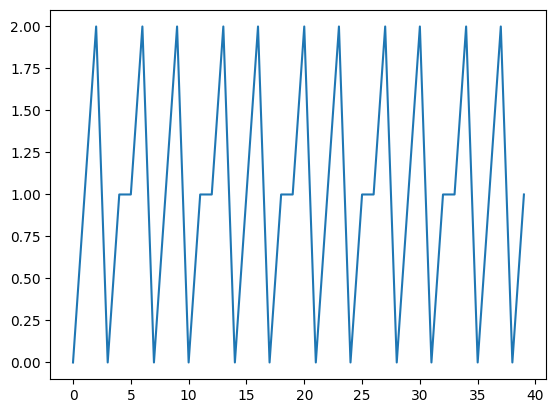

In [7]:
plt.plot(sequences[2][0:40])
plt.show()

In [8]:
complex_res = ComplexReservoir(n_qubits=5, backend=backend)
complex_data = complex_res.run(timeseries=sequences[2], shots=10000)

X_train, X_test, y_train, y_test = train_test_split(complex_data[5:], np.roll(sequences[2], -1)[5:], test_size=0.33, random_state=171)

model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_train, y_train)
print("Model", 2, "KNN Classifier Score Using Standard Reservoir:", model.score(X_test, y_test))

predictions[2] = complex_res.predict(
    num_pred=20,
    model=model,
    from_series=sequences[2],
    shots=10000
)

Model 2 KNN Classifier Score Using Standard Reservoir: 0.8967391304347826


Predicting...: 100%|██████████| 20/20 [01:10<00:00,  3.50s/it]


---

## Plot Creation

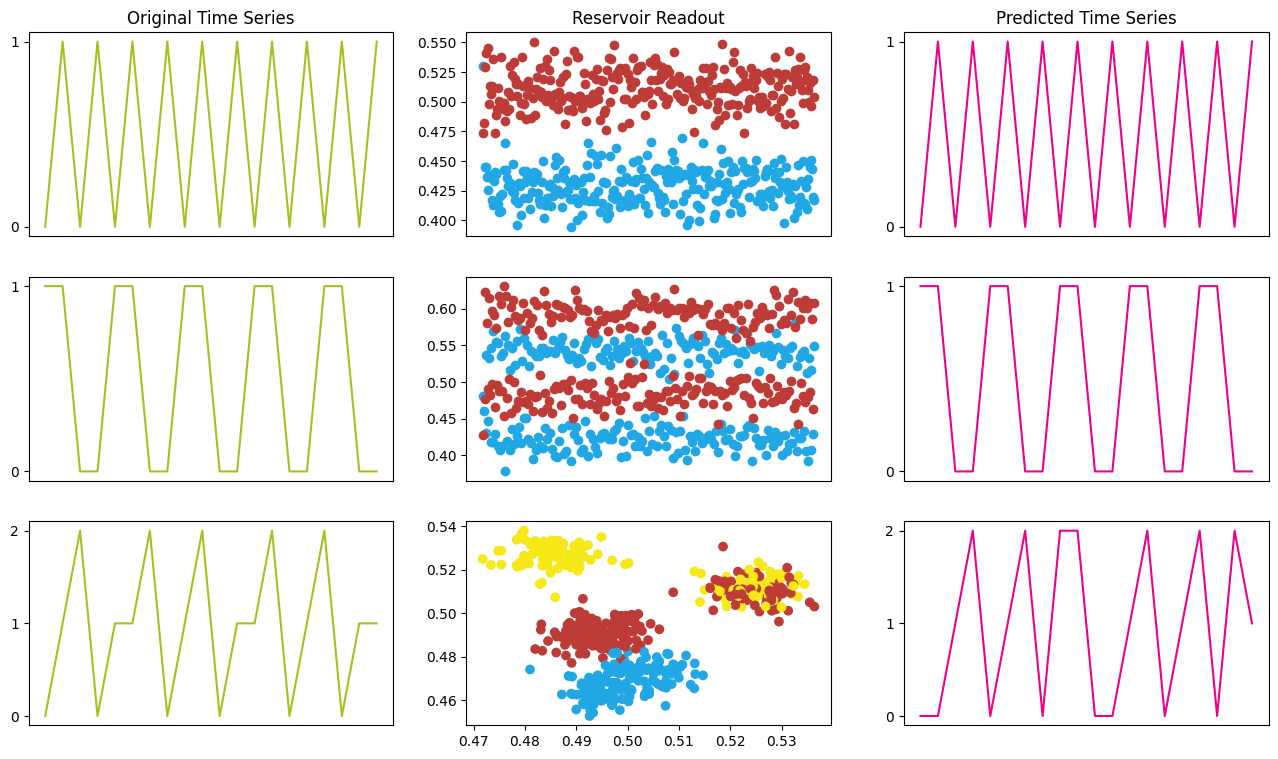

In [9]:
fig, axs = plt.subplots(3, 3)
fig.set_size_inches(16, 9)

colours = ["#22A7E5", "#BE3C37", "#F7E918"]

axs[0, 0].set_title("Original Time Series")
axs[0, 1].set_title("Reservoir Readout")
axs[0, 2].set_title("Predicted Time Series")

for i, sequence in enumerate(sequences):
    axs[i, 0].plot(sequence[0:20], color="#A4C21F")
    axs[i, 0].set_xticks([])
    
    if i == 2:
        axs[i, 0].set_yticks([0, 1, 2])
        cmap = ListedColormap(["#22A7E5", "#BE3C37", "#F7E918"])
        axs[i, 1].scatter(complex_data[5:, 0], complex_data[5:, 1], cmap=cmap, c=np.roll(sequences[2], -1)[5:])
        axs[i, 2].set_yticks([0, 1, 2])
    else:
        axs[i, 0].set_yticks([0, 1])
        axs[i, 1].set_xticks([])
        for j, category in enumerate(np.unique(sequence)):
            mask = category == np.roll(sequence, -1)
            axs[i, 1].plot(np.arange(len(data[i]))[mask], data[i][mask], marker='o', lw=0, color=colours[j])
        axs[i, 2].set_yticks([0, 1])
    
    axs[i, 2].set_xticks([])
    axs[i, 2].plot(predictions[i], color="#EC008C")

plt.show()
